# Notebook for Testing the plotting of CLV Data for the PO Model

### Imports

In [51]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import jit, prange

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [56]:
open('output_09_10_2020_12:38:28.txt', "w")

<_io.TextIOWrapper name='output_09_10_2020_12:38:28.txt' mode='w' encoding='UTF-8'>

### Open Data File

In [37]:
## System Parameters
N       = 128
k0      = 1
alpha   = 2.9
beta    = 0.0 
iters   = 400000
m_end   = 8000
m_iters = 50
trans   = 10000
u0      = "RANDOM"


In [38]:
## Read open data file
results_dir = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]".format(N, k0, alpha, beta, u0)
filename    = "/CLVData_ITERS[{},{},{}]_TRANS[{}]".format(iters, m_end, m_iters, trans)

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/" + results_dir

In [39]:
HDFfileData = h5py.File(input_dir + results_dir + filename + '.h5', 'r')
print("\n\nData File: {}.h5\n".format(results_dir + filename))



Data File: /RESULTS_N[128]_k0[1]_ALPHA[2.900]_BETA[0.000]_u0[RANDOM]/CLVData_ITERS[400000,8000,50]_TRANS[10000].h5



### Read In Data

In [40]:
## Read in datasets
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:]
amps   = HDFfileData['Amps'][:]
lce    = HDFfileData['LCE'][:, :]
CLVs   = HDFfileData['CLVs']

## System Parameters
num_tsteps = len(time);
num_clv_steps = CLVs.shape[0]
num_osc    = phases.shape[1];
kmin       = k0 + 1;
kmax       = num_osc - 1;
dof        = num_osc - kmin

In [41]:
## Reshape the CLV data
clv_dims = CLVs.attrs['CLV_Dims']
CLV      = np.reshape(CLVs, (CLVs.shape[0], dof, dof))

### Compute Angles Between Vectors

In [42]:
@jit(nopython = True)
def compute_angles_t(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                mat = np.transpose(CLV[t, :, :])
                angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[i, :], mat[j, :])))
    
    return angles

In [43]:
@jit(nopython = True)
def compute_angles(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                mat = CLV[t, :, :]
                angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[:, i], mat[:, j])))
    
    return angles

In [44]:
%%timeit 
angles = compute_angles_t(CLV, num_clv_steps, dof)
# print(angles.shape)

<ipython-input-42-115130022f69>:9: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (readonly array(float64, 1d, A), readonly array(float64, 1d, A))
  angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[i, :], mat[j, :])))


470 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit
angles = compute_angles(CLV, num_clv_steps, dof)

<ipython-input-43-eb129656c53b>:9: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (readonly array(float64, 1d, A), readonly array(float64, 1d, A))
  angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[:, i], mat[:, j])))


469 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Compute the Squared Time Averaged Lyapunov Vector Components

In [46]:
@jit(nopython = True)
def compute_zdata(clv, num_tsteps, dof):
    
    z_data   = np.zeros((dof, dof))
    
    for t in range(num_tsteps):
        z_data += np.square(clv[t, :, :])
    
    z_data = z_data / num_tsteps
    
    return z_data

In [47]:
zdata = compute_zdata(CLV, num_clv_steps, dof)

## Plot the Data

### Squared Time Averaged Lyapunov Vector Components

In [48]:
# find the zero Lyap Exp
minval  = np.amin(np.absolute(lce[-1, :]))
minindx = np.where(np.absolute(lce[-1, :]) == minval)
minindx_el,  = minindx
print(minindx_el)
zeroindx = minindx_el[0]

# Extract positive and neg Exponents
lce_pos = lce[-1, :minindx_el[0]]
lce_neg = lce[-1, minindx_el[0] + 1:]

# Extract positive and negative vectors
CLV_expand   = CLV[0, :, :minindx_el[0]]
CLV_zero     = CLV[0, :, :minindx_el[0]]
CLV_contract = CLV[0, :, minindx_el[0] + 1:]

[4]


In [24]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.get_backend()

plt.figure()
plt.plot(np.arange(20), np.arange(20)**2)
plt.draw()

<IPython.core.display.Javascript object>

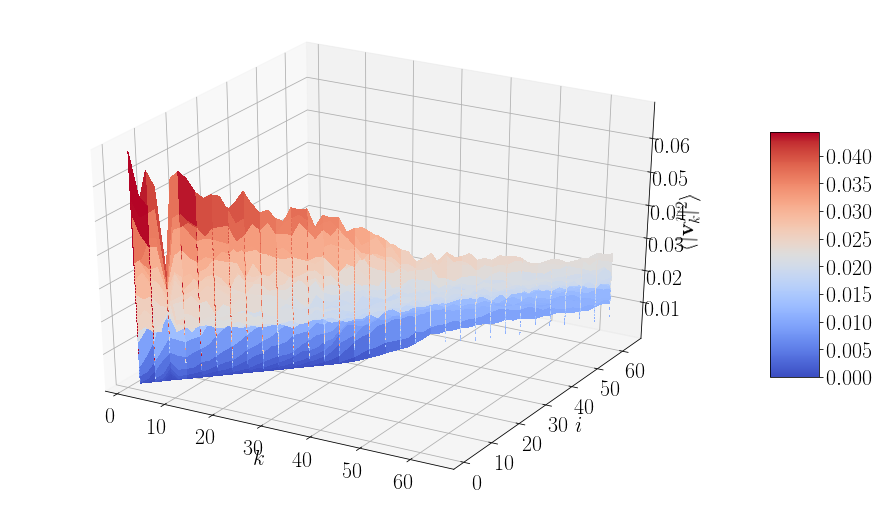

In [49]:

fig = plt.figure(figsize = (16, 9))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(range(kmin, num_osc), range(1, dof + 1), zdata, cmap = cm.coolwarm, linewidth = 0, antialiased = False) 
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$i$")
ax.set_zlabel(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

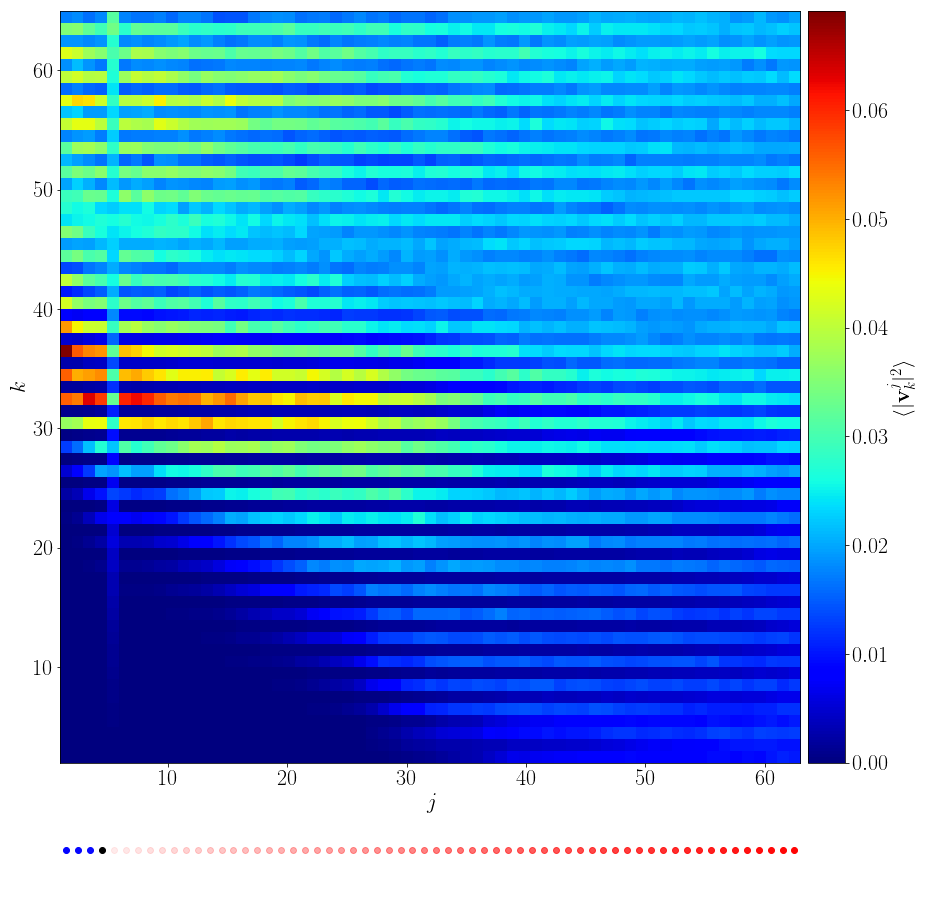

In [50]:


fig = plt.figure(figsize = (16, 16))
gs  = GridSpec(1, 1)

ax2 = fig.add_subplot(gs[0, 0])
im  = ax2.imshow(np.flipud(zdata), cmap = cm.jet, extent = [1, dof, kmin, num_osc])
ax2.set_xlabel(r"$j$")
ax2.set_ylabel(r"$k$")
div2  = make_axes_locatable(ax2)
cax2  = div2.append_axes('right', size = '5%', pad = 0.1)
cbar = plt.colorbar(im, cax = cax2, orientation = 'vertical')
cbar.set_label(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
# ax21  = div2.append_axes('left', size = '5%', pad = 0.8, sharey = ax2)
ax22  = div2.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax2)
for i in range(1, dof + 1):
    if i == zeroindx:
#         ax21.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
#         ax21.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
#         ax21.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
# ax21.set_ylim(1, dof)
ax22.set_xlim(1, dof)
# ax21.axis("off")
ax22.axis("off")

# plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/TimeAverage.pdf")  
# plt.close()

plt.show()

In [2]:
import matplotlib as mpl
mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

### Angles Plots

In [ ]:
fig = plt.figure(figsize = (16, 16))
gs  = GridSpec(3, 2)

t = 1000

cmap_new = cm.jet
# cmap_new.set_bad(color = 'black')

# Angles
ax1 = fig.add_subplot(gs[0, 0])
data = np.mean(angles[:, :, :], axis = 0)
im1  = ax1.imshow(np.flipud(data + data.T - np.diag(np.diag(data))), cmap = cm.gnuplot2, extent = [1, dof, 1, dof], vmin = 0.0, vmax = np.pi/2.0)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$j$")
div1  = make_axes_locatable(ax1)
cax1  = div1.append_axes('right', size = '5%', pad = 0.1)
cbar1 = plt.colorbar(im1, cax = cax1, orientation = 'vertical')
cbar1.set_ticks([ 0.0, np.pi/4.0, np.pi/2.0])
cbar1.set_ticklabels([r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
cbar1.set_label(r"$\langle\theta_{\mathbf{v}_i, \mathbf{v}_j}\rangle$")
ax11  = div1.append_axes('left', size = '5%', pad = 0.8, sharey = ax1)
ax12  = div1.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax1)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax11.set_ylim(1, dof)
ax12.set_xlim(1, dof)
ax11.axis("off")
ax12.axis("off")
ax12.legend(loc = "lower right", bbox_to_anchor = (-0.01, -0.1), fancybox = True, framealpha = 1, shadow = True)

## Time Averaged
ax2 = fig.add_subplot(gs[0, 1])
im  = ax2.imshow(np.flipud(zdata), cmap = cm.jet, extent = [1, dof, kmin, num_osc])
ax2.set_xlabel(r"$j$")
ax2.set_ylabel(r"$k$")
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size = '5%', pad = 0.1)
cbar = plt.colorbar(im, cax = cax2, orientation = 'vertical')
cbar.set_label(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
ax21  = div2.append_axes('left', size = '5%', pad = 0.8, sharey = ax2)
ax22  = div2.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax2)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax22.set_xlim(1, dof)
ax21.axis("off")
ax22.axis("off")
plt.suptitle(r"$N = {}, k_0 = {}, \alpha = {}, \beta = {}$".format(N, k0, alpha, beta))


ax3 = fig.add_subplot(gs[1, 0:])
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
ax3.plot(bin_centers, hist)
ax3.set_xlim(0.0, np.pi/2.0)
ax3.set_xlabel(r"$\theta$")
ax3.set_xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
ax3.set_ylabel(r"PDF")
ax3.set_yscale("log")
ax3.legend([r"$\theta_1$", r"$\theta_2$"], fancybox = True, framealpha = 1, shadow = True)
ax3.set_title(r"Distribution of Angles Between Tangent Subspaces")


ax4 = fig.add_subplot(gs[2, 0])


# # plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/Angles1.pdf")  

plt.tight_layout(rect = (0, 0, 1, 0.96))
plt.show()

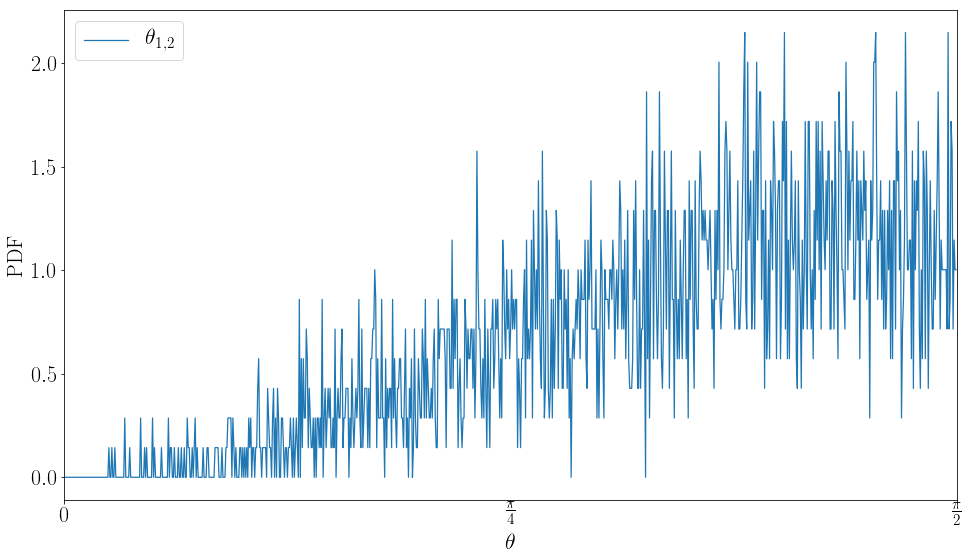

In [356]:
plt.figure()
hist, bins  = np.histogram(angles[:, 6, 3], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$"])
plt.ylabel(r"PDF")
plt.show()

15


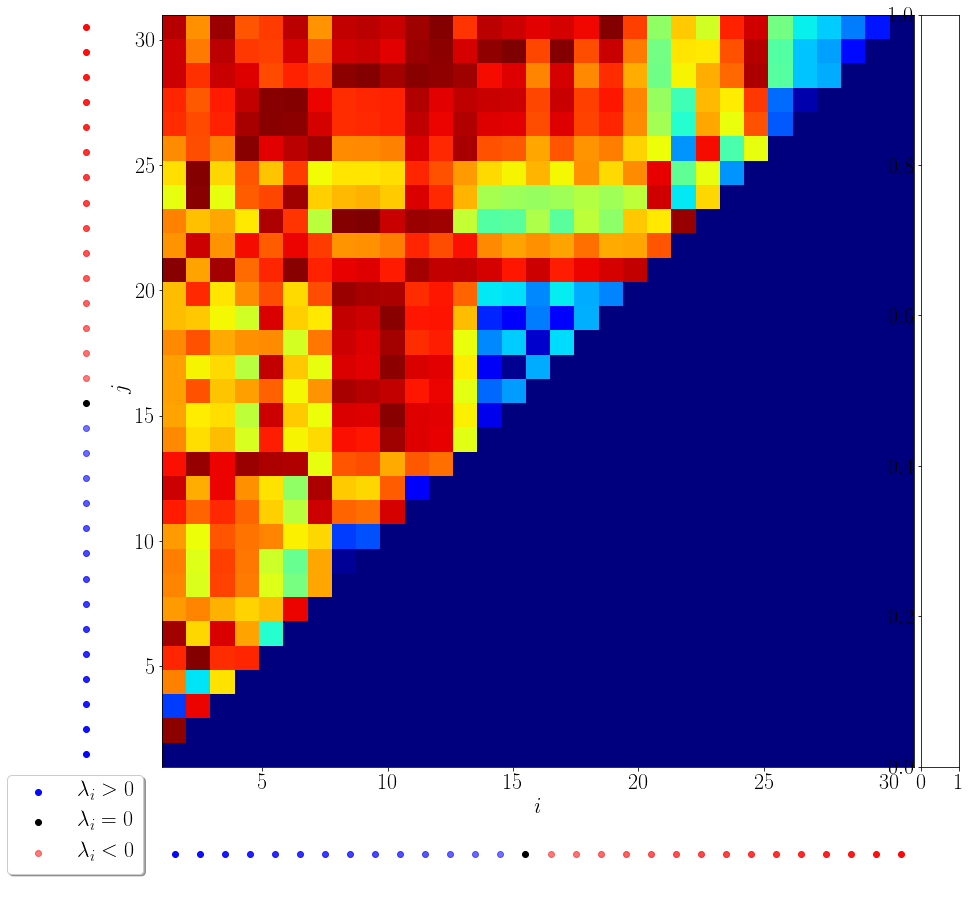

In [474]:
fig = plt.figure(figsize = (16, 16))
gs  = GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0, 0])
im  = ax1.imshow(np.flipud(angles[t, :, :]), cmap = cmap_new, extent = [1, dof, 1, dof], vmin = 0.0, vmax = np.pi/2.0)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$j$")
div1  = make_axes_locatable(ax1)
cax1  = div1.append_axes('right', size = '5%', pad = 0.1)
ax11  = div1.append_axes('left', size = '5%', pad = 0.8, sharey = ax1)
ax12  = div1.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax1)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax11.set_ylim(1, dof)
ax12.set_xlim(1, dof)
ax11.axis("off")
ax12.axis("off")
ax12.legend(loc = "lower right", bbox_to_anchor = (-0.01, -0.01), fancybox = True, framealpha = 1, shadow = True)

plt.draw()
plt.show()


In [73]:
def compute_angles_subspaces(A1, B1, A2, B2, num_clv_steps):
    
    angles1 = np.zeros((num_clv_steps))
    angles2 = np.zeros((num_clv_steps))
    
    for t in range(1, num_clv_steps):
        angles1[t] = subspace_angles(A1[t, :, :], B1[t, :, :])[0]
        
        angles2[t] = subspace_angles(A2[t, :, :], B2[t, :, :])[0]
        
    return angles1, angles2

In [76]:
zeroindx = minindx_el[0]
print(zeroindx)
start = TIME.perf_counter()
theta1, theta2 = compute_angles_subspaces(CLV[:, :, :zeroindx + 1], CLV[:, :, zeroindx + 1:], CLV[:, :, :zeroindx], CLV[:, :, zeroindx:], num_clv_steps)
end = TIME.perf_counter()
print("\nTime: {:5.8f}s\n\n".format(end - start))


0


ValueError: On entry to DGESDD parameter number 10 had an illegal value

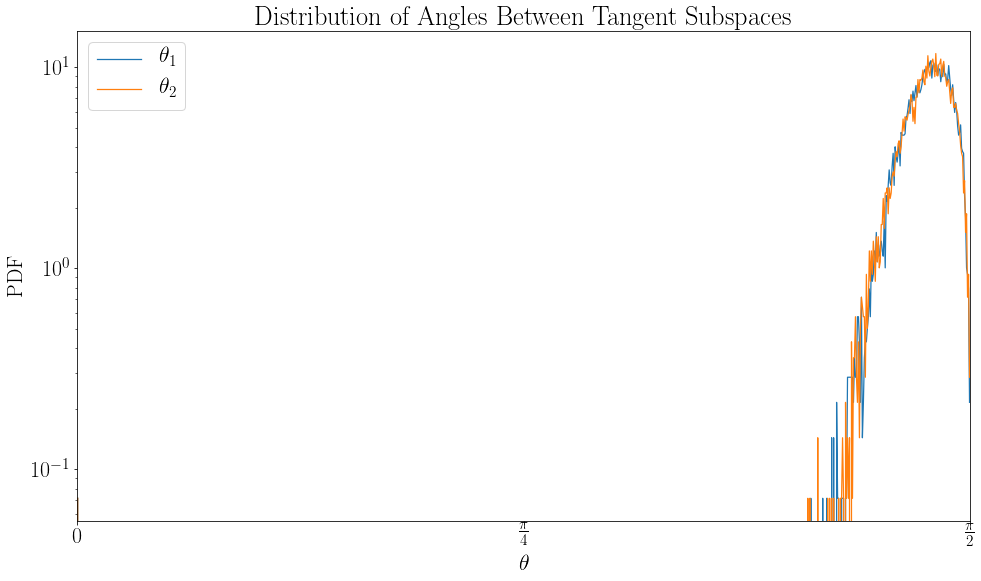

In [306]:
plt.figure()
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$", r"$\theta_{1,3}$", r"$\theta_{2,3}$"])
plt.ylabel(r"PDF")
plt.yscale("log")
plt.legend([r"$\theta_1$", r"$\theta_2$"])
plt.title(r"Distribution of Angles Between Tangent Subspaces")
plt.show()